# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# My Objective


My goal: to instantiate a machine learning model that can predict some type of event (whether it was a purchase or not),
check which age groups have greater adherence to viewing/purchasing the products (or at least cooperated with the research).

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### First check on our Data

In [2]:
def show_basics(df):
    '''
    Input: Pandas Dataframe
    Output: Basic dataframe information (shape and null count)
    Return: None
    '''
    print('DataFrame Shape:{}\n'.format(df.shape))
    print('Null count:\n{}\n\n'.format(df.isnull().sum()))
    df.info()

In [3]:
show_basics(portfolio)

DataFrame Shape:(10, 6)

Null count:
channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [4]:
show_basics(profile)

DataFrame Shape:(17000, 5)

Null count:
age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [5]:
show_basics(transcript)

DataFrame Shape:(306534, 4)

Null count:
event     0
person    0
time      0
value     0
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


# Data Visualization
The purpose of this part is to visualize how some of the classes we have behave

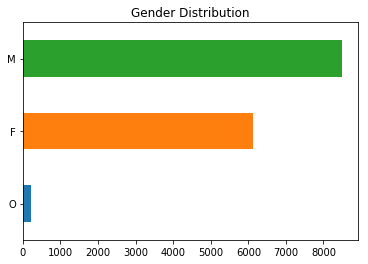

In [6]:
plt.title('Gender Distribution')
profile['gender'].value_counts().sort_values().plot(kind = 'barh')

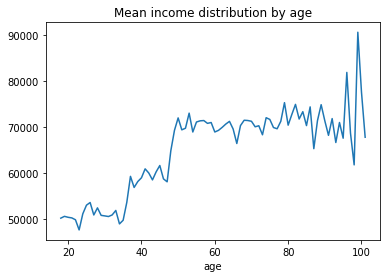

In [7]:
plt.title('Mean income distribution by age')
profile.groupby('age')['income'].mean().plot(kind = 'line')

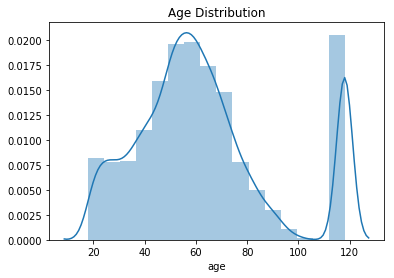

In [8]:
plt.title('Age Distribution')
sns.distplot(profile['age'], bins = 'sturges')

<b>Considering the results above, applying the formula of 'sturges' to check our Bins, I consider it a good option to remove users whose age is set to 118 years old, because checking our normal distribution, the other ages are better distributed

In [9]:
# to not change the values of our original dataframe, I will save this query in another dataframe
profile_not_118 = profile.query('age != 118')

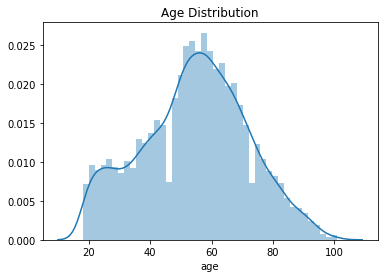

In [10]:
plt.title('Age Distribution')
sns.distplot(profile_not_118['age'])

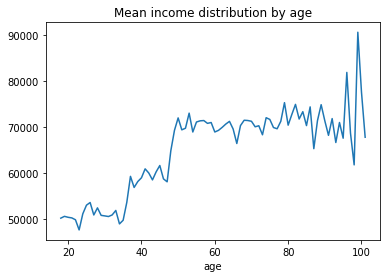

In [11]:
plt.title('Mean income distribution by age')
profile_not_118.groupby('age')['income'].mean().plot(kind = 'line')

<b>checking the average income distribution, we see that removing users with age = 118 did not affect the previous result, so we can keep these changes.<b>

### Data Cleaning and Preprocessing
#### Portfolio

We'll first transform the channels column on a matrix

In [12]:
chanel_matrix = MultiLabelBinarizer().fit_transform(portfolio.channels)

In [13]:
df_portofolio_matrix = pd.DataFrame(chanel_matrix, columns=['channel_email', 'channel_mobile', 'channel_social', 'channel_web'])

In [14]:
# now that we got this matrix, we'll concat with the portfolio dataframe
df_portofolio_matrix

,channel_email,channel_mobile,channel_social,channel_web
0,1,1,1,0
1,1,1,1,1
2,1,1,0,1
3,1,1,0,1
4,1,0,0,1
5,1,1,1,1
6,1,1,1,1
7,1,1,1,0
8,1,1,1,1
9,1,1,0,1


In [15]:
portfolio1 = pd.concat([portfolio,df_portofolio_matrix], axis=0,sort=True)

In [16]:
df_portofolio_encoded_channel = portfolio.copy()
df_portofolio_encoded_dummy = pd.get_dummies(df_portofolio_encoded_channel.channels.apply(pd.Series).stack()).sum(level=0)
df_portofolio_encoded_channel = pd.concat([df_portofolio_encoded_channel, df_portofolio_encoded_dummy], axis=1)

In [17]:
# after this transformation, well transform the offer_type in a numeric value
df_portofolio_encoded_channel

,channels,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


In [18]:
# bogo = 0, discount = 1, informational = 2
df_portofolio_encoded_channel['offer_type'] = df_portofolio_encoded_channel['offer_type'].astype('category').cat.codes

In [19]:
df_portofolio_encoded_channel

,channels,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,0,10,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,0,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,2,0,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,5,1,0,0,1
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,3,1,1,1,1
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,1,2,1,1,1,1
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,2,0,1,1,1,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,0,5,1,1,1,1
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,1,2,1,1,0,1


Now we got a dataframe with a matrix on the channels and changed the offer type to numeric

#### Profile

In [20]:
# first well transform the became_member_on in datetime format
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [21]:
# checking null values
profile.isnull().mean()

age                 0.000000
became_member_on    0.000000
gender              0.127941
id                  0.000000
income              0.127941
dtype: float64

In [22]:
# we created this dataset, and removing all the 118 age values, we removed the missing income as well
profile_not_118.isnull().mean()

age                 0.0
became_member_on    0.0
gender              0.0
id                  0.0
income              0.0
dtype: float64

In [23]:
# the difference between those 2 datasets are minimal, we can keep using the 2ª df profile_not_118
len(profile) - len(profile_not_118)

2175

In [24]:
profile_not_118 = profile_not_118.reset_index(drop = True)
profile_not_118['became_member_on'] = pd.to_datetime(profile_not_118['became_member_on'], format='%Y%m%d')
profile_not_118

,age,became_member_on,gender,id,income
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
1,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
2,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
3,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
4,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0
5,61,2017-09-11,F,aa4862eba776480b8bb9c68455b8c2e1,57000.0
6,26,2014-02-13,M,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0
7,62,2016-02-11,F,31dda685af34476cad5bc968bdb01c53,71000.0
8,49,2014-11-13,M,62cf5e10845442329191fc246e7bcea3,52000.0
9,57,2017-12-31,M,6445de3b47274c759400cd68131d91b4,42000.0


In [25]:
# now well create a gender group, M = 0 F = 1 O = 2
gender_map = {'M':0, 'F':1, 'O':2}
profile_not_118['gender_group'] = profile_not_118['gender'].map(gender_map)

In [26]:
# now well add the age percentill
profile_not_118['age_percentill'] = profile_not_118['age'].astype('str').str[0] + '0'
profile_not_118['age_percentill'] = profile_not_118['age_percentill'].astype('int')

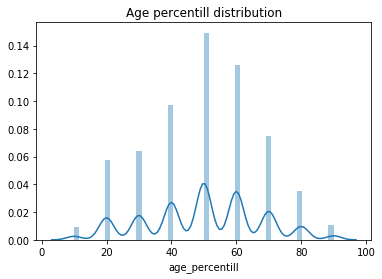

In [27]:
# checking our age percentill distribution
plt.title('Age percentill distribution')
sns.distplot(profile_not_118['age_percentill'])

In [28]:
# adding category codes to our age_percentill groups
profile_not_118['percentill_group_code'] = profile_not_118['age_percentill'].astype('category').cat.codes

In [29]:
# adding now income groups 30000 <> 59999 group 1, 60000 <> 89999 group 2 and from 90000> group 3
profile_not_118.loc[(profile_not_118['income'] >= 30000.) & (profile_not_118['income'] <= 59999.) , 'income_group_number'] = 1
profile_not_118.loc[(profile_not_118['income'] >= 60000.) & (profile_not_118['income'] <= 89999.) , 'income_group_number'] = 2
profile_not_118.loc[(profile_not_118['income'] > 90000) , 'income_group_number'] = 3

In [30]:
profile_not_118.head()

,age,became_member_on,gender,id,income,gender_group,age_percentill,percentill_group_code,income_group_number
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1,50,4,3.0
1,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,70,6,3.0
2,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,0,60,5,2.0
3,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,0,60,5,1.0
4,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,50,4,1.0


### Transcript

In [31]:
# first we'll get a offer type matrix using the event columns, then concat with our original dataframe
transcript_matrix = pd.get_dummies(transcript['event'])
transcript = pd.concat([transcript, transcript_matrix], axis=1 )

In [32]:
transcript.head()

,event,person,time,value,offer completed,offer received,offer viewed,transaction
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0


In [33]:
# now extract the values of our value column
transcript['offer_id'] = [[*i.values()][0]if [*i.keys()][0] in ['offer id','offer_id'] else None for i in transcript.value]
transcript['amount_spent'] = [np.round([*i.values()][0], decimals=3)if [*i.keys()][0] == 'amount' else None for i in transcript.value]

In [34]:
transcript.head()

,event,person,time,value,offer completed,offer received,offer viewed,transaction,offer_id,amount_spent
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


### Merging df's

In [35]:
df_portofolio_encoded_channel.rename(columns={'id': 'offer_id'}, inplace = True)

In [36]:
# merge between portfolio and transcript df's
df_merged_portfolio_transcript = pd.merge(df_portofolio_encoded_channel, transcript, on='offer_id')

In [37]:
# renaming person columns to customer_id
df_merged_portfolio_transcript.rename(columns = {'person':'customer_id'}, inplace = True)

In [38]:
# renaming id to customer_id
profile_not_118.rename(columns={'id': 'customer_id'}, inplace = True)

In [39]:
# merging df_merged_portfolio_transcript with the profile dataframe as well
df_merged_portfolio_transcript_profile = pd.merge(df_merged_portfolio_transcript, profile_not_118, on='customer_id')

#### Creating df for prediction

In [40]:
# creating a df for predictions
df_predict = df_merged_portfolio_transcript_profile.copy()

In [41]:
df_predict.drop(['offer_id','channels','customer_id','gender','age_percentill','value','amount_spent'],
               axis = 1, inplace = True)

In [42]:
# transforming event column on category
df_predict['event'] = df_predict['event'].astype('category').cat.codes

In [43]:
# filtering for only events that are completed or viewed
df_predict = df_predict.query('event != 1')

In [44]:
# checking for duplicates
len(df_predict)

82304

In [45]:
len(df_predict.drop_duplicates())

81930

In [46]:
df_predict = df_predict.drop_duplicates()

In [47]:
# filling income_group_number with its previous value
df_predict.isnull().mean()

difficulty               0.000000
duration                 0.000000
offer_type               0.000000
reward                   0.000000
email                    0.000000
mobile                   0.000000
social                   0.000000
web                      0.000000
event                    0.000000
time                     0.000000
offer completed          0.000000
offer received           0.000000
offer viewed             0.000000
transaction              0.000000
age                      0.000000
became_member_on         0.000000
income                   0.000000
gender_group             0.000000
percentill_group_code    0.000000
income_group_number      0.008861
dtype: float64

In [48]:
df_predict['income_group_number'].fillna(method = 'ffill', inplace = True)

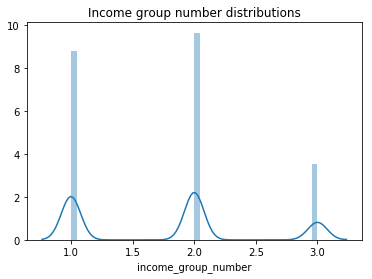

In [49]:
plt.title('Income group number distributions')
sns.distplot(df_predict['income_group_number'])

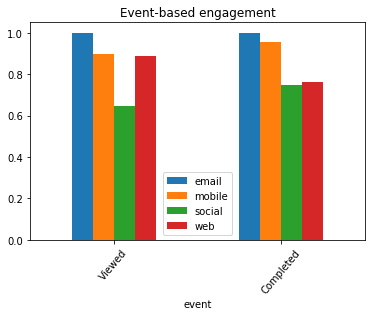

In [50]:
df_predict.groupby('event')[['email','mobile','social','web']].mean().plot(kind = 'bar')
plt.title('Event-based engagement')
plt.xticks(range(2), ('Viewed', 'Completed'), rotation = 50)
plt.show()

### Preparing X and Y variables

In [51]:
Y = df_predict['event']
X = df_predict[['time','difficulty','duration','reward','offer_type','percentill_group_code','income_group_number','gender_group']]

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=356)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<b> Since we have unbalanced data, we will focus on some metrics, f1-Score and precision.
    F1_score is a metric which is used to balance recall & precision and to deal with imbalanced labels.

# Choosing ML Models

We'll be using classifiers for our predictions, and will be the following:<br>
AdaBoostClassifier<br>
GradientBoostingClassifier<br>
ExtraTreesClassifier<br>
RandomForestClassifier

PS: we'll not be changing its hyperparameters

In [53]:
def model_testing(ml_model):
    '''
    input: Instantiated machine learning model
    output: Classification report and confusion matrix
    return: None
    '''
    ml_model.fit(X_train, y_train)
    predict = ml_model.predict(X_test)
    print(classification_report(y_test, predict))
    print(confusion_matrix(y_test, predict))

In [54]:
ada_model = AdaBoostClassifier()
gradient = GradientBoostingClassifier()
extra_tree = ExtraTreesClassifier()
random_forest = RandomForestClassifier()

In [55]:
model_testing(ada_model)

             precision    recall  f1-score   support

          0       0.62      0.48      0.54     10682
          2       0.70      0.81      0.75     16355

avg / total       0.67      0.68      0.67     27037

[[ 5093  5589]
 [ 3092 13263]]


In [56]:
model_testing(gradient)

             precision    recall  f1-score   support

          0       0.63      0.51      0.56     10682
          2       0.72      0.81      0.76     16355

avg / total       0.68      0.69      0.68     27037

[[ 5437  5245]
 [ 3183 13172]]


In [57]:
model_testing(extra_tree)

             precision    recall  f1-score   support

          0       0.53      0.55      0.54     10682
          2       0.70      0.69      0.69     16355

avg / total       0.63      0.63      0.63     27037

[[ 5827  4855]
 [ 5136 11219]]


In [58]:
model_testing(random_forest)

             precision    recall  f1-score   support

          0       0.54      0.49      0.51     10682
          2       0.69      0.73      0.71     16355

avg / total       0.63      0.63      0.63     27037

[[ 5241  5441]
 [ 4437 11918]]


### Little refinement on our gradient model

In [59]:
from sklearn.model_selection import GridSearchCV

In [72]:
param_list = {'loss' : ['deviance', 'exponential'],
             'learning_rate':[.1,.2,.3],
             'n_estimators' : [100, 150],
             'min_samples_split' : [2, 3, 4]}

In [80]:
cv = GridSearchCV(gradient, param_grid = param_list, return_train_score = True, verbose = 3)

In [81]:
cv.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] learning_rate=0.1, loss=deviance, min_samples_split=2, n_estimators=100 
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=2, n_estimators=100, score=0.699109240942128, total=   2.0s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV]  learning_rate=0.1, loss=deviance, min_samples_split=2, n_estimators=100, score=0.695578510138274, total=   2.0s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=2, n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s


[CV]  learning_rate=0.1, loss=deviance, min_samples_split=2, n_estimators=100, score=0.6924632453407662, total=   1.9s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=2, n_estimators=150 
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=2, n_estimators=150, score=0.7009126181758566, total=   2.9s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=2, n_estimators=150 
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=2, n_estimators=150, score=0.696562277969066, total=   2.9s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=2, n_estimators=150 
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=2, n_estimators=150, score=0.6949773186861234, total=   3.0s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=3, n_estimators=100 
[CV]  learning_rate=0.1, loss=deviance, min_samples_split=3, n_estimators=100, score=0.699109240942128, total=   1.9s
[CV] learning_rate=0.1, loss=deviance, min_samples_split=3, n_estimators=100 
[CV]  learning_ra

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  4.6min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'loss': ['deviance', 'exponential'], 'learning_rate': [0.1, 0.2, 0.3], 'n_estimators': [100, 150], 'min_samples_split': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=3)

### applying the changes

In [83]:
gradient = GradientBoostingClassifier(min_samples_split=4, learning_rate=.3, loss = 'exponential', n_estimators=100)

model_testing(gradient)

             precision    recall  f1-score   support

          0       0.63      0.54      0.58     10682
          2       0.73      0.79      0.76     16355

avg / total       0.69      0.69      0.69     27037

[[ 5817  4865]
 [ 3442 12913]]


# Conclusion

Overall, our GradientBoostingClassifier model had the best performance. And that it could perform even better if we messed with its hyperparameters.<br>
But all models performed in very similar ways, so I imagine that all of them, with the necessary changes, can perform even better!

The age percentile that most consumed starbucks products is between 40 and 60 years old.

With the grouping that was carried out in the income part, the groups that most participated were groups 1 and 2.

we could also verify that most of the engagement in the events was based on email, followed by mobile.
And most of the events completed were by email basis.

With the removal of the age of 118, we were able to get very close to a normal curvature to apply to our model, so I imagine this was a good move, given that even with this change, there was no impact on those who reported income (with the removal from age 118, we also remove all nulls that did not report income).